Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import os
import PIL
import pathlib
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import load_img

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='training',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='validation',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

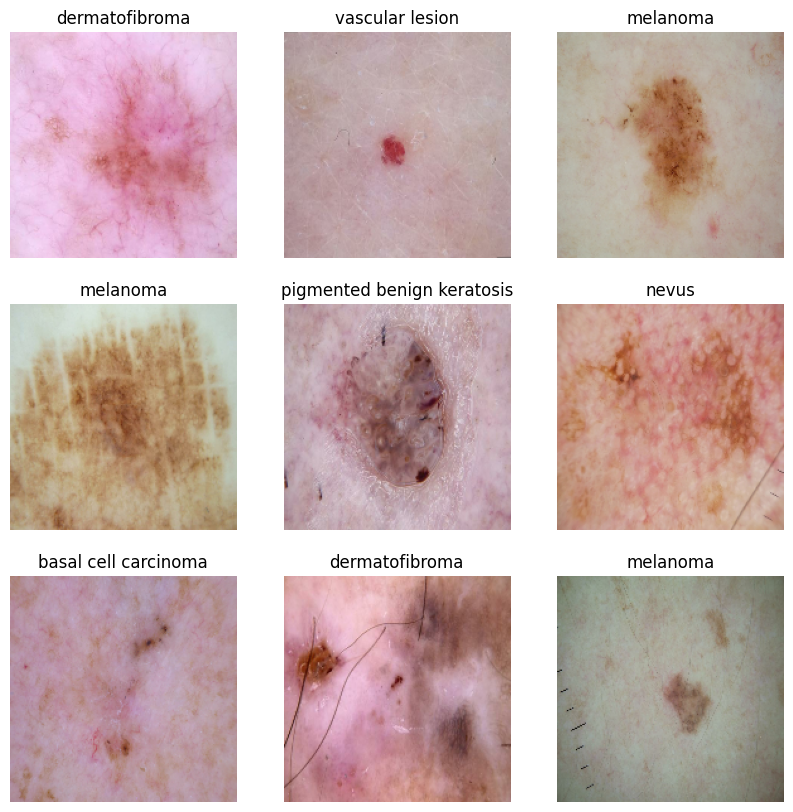

In [9]:
### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
### Your code goes here
# Number of target labels are 9
target_labels = 9
normalization_layer = layers.Normalization()

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [13]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 2508s 3s/step - accuracy: 0.1915 - loss: 2.1800 - val_accuracy: 0.3779 - val_loss: 1.7172
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 38s 17ms/step - accuracy: 0.4389 - loss: 1.4948 - val_accuracy: 0.5026 - val_loss: 1.3700
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5378 - loss: 1.2255 - val_accuracy: 0.5590 - val_loss: 1.1940
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6183 - loss: 1.0334 - val_accuracy: 0.6407 - val_loss: 1.0396
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6892 - loss: 0.8461 - val_accuracy: 0.6800 - val_loss: 0.9753
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7777 - loss: 0.6250 - val_accuracy: 0.7283 - val_loss: 0.7979
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8229 - loss: 0.5095 - val_accuracy: 0.7298 - val_loss: 0.7831
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8510 - loss: 0.4209 - val_ac

### Visualizing training results

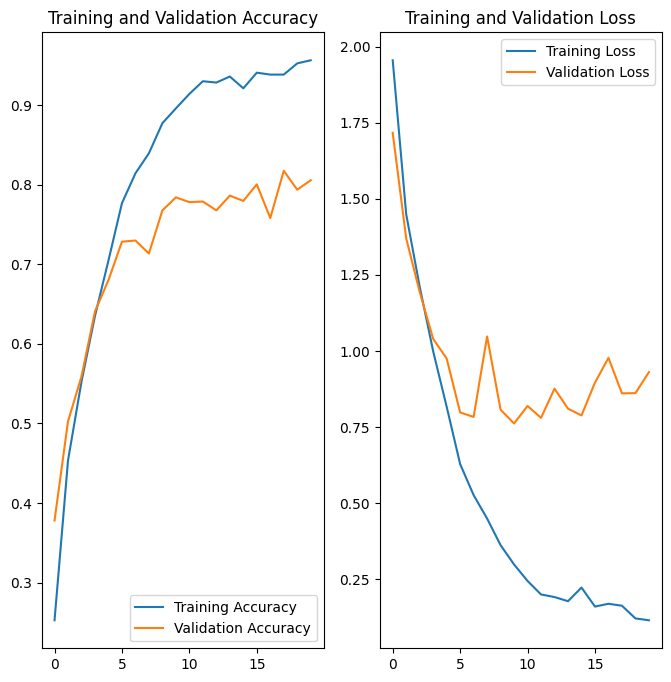

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here
1. The model's training accuracy steadily increases up to 90%, while validation accuracy remains consistently around 55%.

2. A high training accuracy suggests that the model has memorized patterns, including noise, within the training data. However, its poor performance on validation data indicates a lack of generalizability.

3. These observations confirm the presence of overfitting. To address this issue, data augmentation techniques will be employed. Given the limited training data available, new samples will be generated by applying slight modifications to existing data, such as horizontal and vertical flipping, minor rotations, and other transformations. These augmented samples will then be used to train the model and improve its generalization.

In [19]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
augmentation_data = keras.Sequential([
                                      layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
                                      layers.RandomRotation(0.1),
                                      layers.RandomZoom(0.1),
])

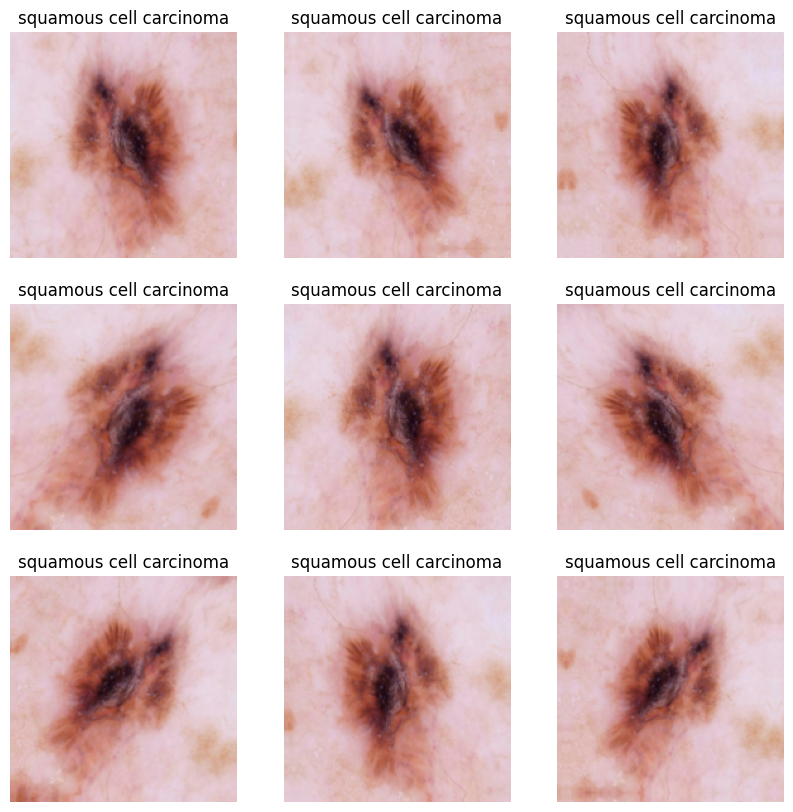

In [21]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_images = augmentation_data(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [22]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = Sequential([
  augmentation_data,
  layers.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])


### Compiling the model

In [24]:
## Your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [25]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.1921 - loss: 2.1818 - val_accuracy: 0.3764 - val_loss: 1.6823
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.3719 - loss: 1.6033 - val_accuracy: 0.3883 - val_loss: 1.5523
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.4140 - loss: 1.5218 - val_accuracy: 0.4855 - val_loss: 1.3586
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.4557 - loss: 1.4148 - val_accuracy: 0.5189 - val_loss: 1.2862
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.5047 - loss: 1.2931 - val_accuracy: 0.5167 - val_loss: 1.2439
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5241 - loss: 1.2255 - val_accuracy: 0.5226 - val_loss: 1.3249
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5202 - loss: 1.2453 - val_accuracy: 0.5457 - val_loss: 1.1784
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.5547 - loss: 1.1653 - val_accu

### Visualizing the results

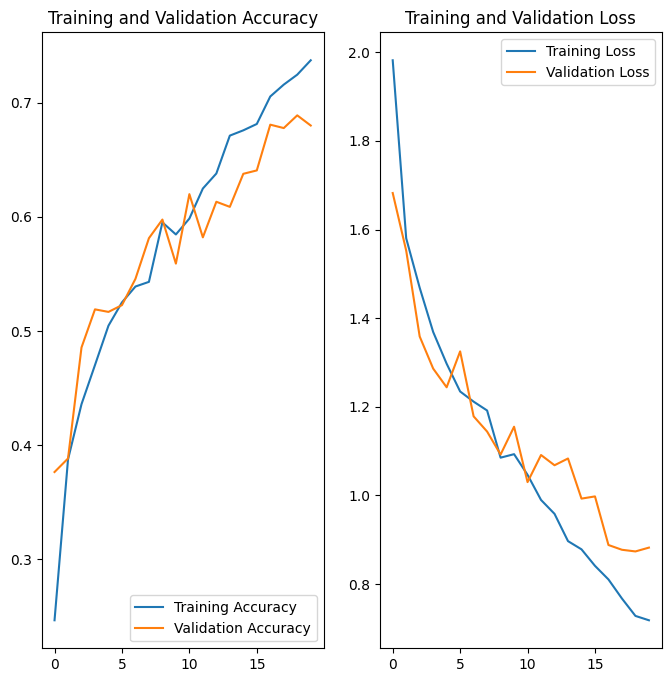

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

***Observations:***

1. By leveraging augmented data, overfitting has been significantly reduced.

2. The training and validation accuracies of the model are now within a similar range.

3. However, both the training and validation accuracies remain low, indicating that the model is now underfitting.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
## Your code goes here.

## find the image path for all class labels (lesions)
images_path_list = [ i for i in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]

## Extract the class labels (lesions)
lesions_list = [ os.path.basename(os.path.dirname(j)) for j in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]
print(len(lesions_list))

In [29]:
# Extract image path and class label in a dictionary
image_dict = dict(zip(images_path_list, lesions_list))
print(list(image_dict.items())[:5])

[('/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0000141.jpg', 'melanoma'), ('/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0000139.jpg', 'melanoma'), ('/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0000142.jpg', 'melanoma'), ('/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0000143.jpg', 'melanoma'), ('/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0000144.jpg', 'melanoma')]


In [30]:
# View the image path and class label in a df
lesions_df = pd.DataFrame(list(image_dict.items()), columns=['Image Path', 'Label'])
lesions_df.head()

,Image Path,Label
0,/content/gdrive/My Drive/Skin cancer ISIC The ...,melanoma
1,/content/gdrive/My Drive/Skin cancer ISIC The ...,melanoma
2,/content/gdrive/My Drive/Skin cancer ISIC The ...,melanoma
3,/content/gdrive/My Drive/Skin cancer ISIC The ...,melanoma
4,/content/gdrive/My Drive/Skin cancer ISIC The ...,melanoma


In [31]:
## Inspecting the distribution of classes in the data
lesions_df[['Label']].value_counts()

,count
Label,
pigmented benign keratosis,462
melanoma,438
basal cell carcinoma,376
nevus,357
squamous cell carcinoma,181
vascular lesion,139
actinic keratosis,114
dermatofibroma,95
seborrheic keratosis,77


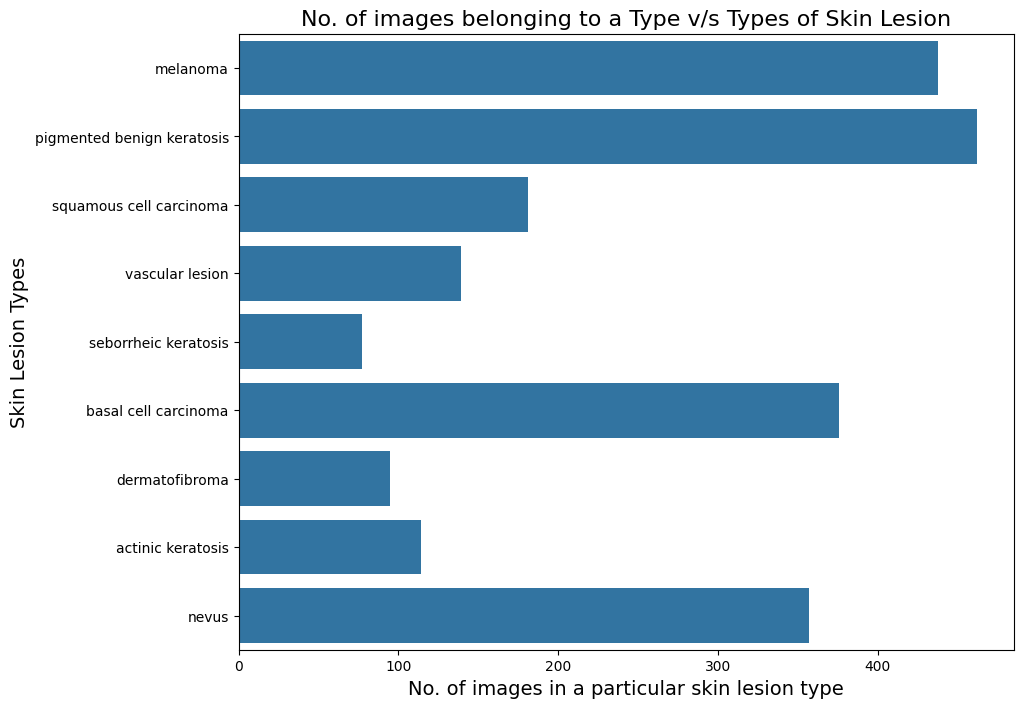

In [34]:
# Visualize the distribution of classes using a countplot

plt.figure(figsize=(10, 8))
sns.countplot(y="Label", data=lesions_df)
plt.title('No. of images belonging to a Type v/s Types of Skin Lesion', fontsize=16)
plt.xlabel('No. of images in a particular skin lesion type', fontsize=14)
plt.ylabel('Skin Lesion Types', fontsize=14)
plt.show()

In [35]:
round(lesions_df[['Label']].value_counts(normalize=True)*100, 2)

,proportion
Label,
pigmented benign keratosis,20.63
melanoma,19.56
basal cell carcinoma,16.79
nevus,15.94
squamous cell carcinoma,8.08
vascular lesion,6.21
actinic keratosis,5.09
dermatofibroma,4.24
seborrheic keratosis,3.44


#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?

***Observations:***

1. A clear class imbalance is present in the training data.

2. The class "seborrheic keratosis" has the fewest samples, making up approximately 3.44% of the dataset.

3. In contrast, "pigmented benign keratosis" and "melanoma" are among the most represented classes, comprising approximately 20.63% and 19.56% of the data, respectively.


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [37]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [38]:
path_to_training_dataset = str(data_dir_train) + '/'

import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D31397ADD50>: 100%|██████████| 500/500 [00:19<00:00, 25.75 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D31BE2F9590>: 100%|██████████| 500/500 [00:19<00:00, 25.37 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D31423B5110>: 100%|██████████| 500/500 [00:24<00:00, 20.14 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D3142193E90>: 100%|██████████| 500/500 [01:32<00:00,  5.42 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7D31394B6E90>: 100%|██████████| 500/500 [01:14<00:00,  6.75 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D31422ED750>: 100%|██████████| 500/500 [00:16<00:00, 29.79 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D3142118310>: 100%|██████████| 500/500 [00:39<00:00, 12.64 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D31394DE410>: 100%|██████████| 500/500 [00:17<00:00, 28.55 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D31425112D0>: 100%|██████████| 500/500 [00:18<00:00, 27.08 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [39]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [40]:
# extracting the augmented image paths in a list
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[:5]

['/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011135.jpg_585062b3-78dd-4248-b7c7-43dce42af802.jpg',
 '/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010245.jpg_0cfdd506-9137-4b34-9dac-4dea592fd8b3.jpg',
 '/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000533.jpg_8d1c8850-ea4a-42f0-86c4-008d5555368e.jpg',
 '/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001105.jpg_11472a1f-6e5c-40bf-a128-f0bb02aea714.jpg',
 '/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011137.jpg_a6325828-7467-4a4c-8b61-df570ad49a70.jpg']

In [41]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:5]

['melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma']

In [42]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [43]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Image Path','Label'])
new_df = pd.concat([lesions_df, df2], ignore_index=True)
new_df.shape

(11239, 2)

In [44]:
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,1462
melanoma,1438
basal cell carcinoma,1376
nevus,1357
squamous cell carcinoma,1181
vascular lesion,1139
actinic keratosis,1114
dermatofibroma,1095
seborrheic keratosis,1077


In [45]:
# Inspecting the classes (% age wise) after adding 500 samples per label
round(new_df['Label'].value_counts(normalize=True)*100, 2)

,proportion
Label,
pigmented benign keratosis,13.01
melanoma,12.79
basal cell carcinoma,12.24
nevus,12.07
squamous cell carcinoma,10.51
vascular lesion,10.13
actinic keratosis,9.91
dermatofibroma,9.74
seborrheic keratosis,9.58


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [46]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [48]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training", # Todo choose the correct parameter value, so that only training data is refered to,,
  image_size = (img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


#### **Todo:** Create a validation dataset

In [49]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation", # Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [50]:
## your code goes here
model = Sequential([
  augmentation_data,
  layers.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [51]:
## your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [52]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 72s 238ms/step - accuracy: 0.2478 - loss: 3.5688 - val_accuracy: 0.1291 - val_loss: 53.6842
Epoch 2/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 75s 218ms/step - accuracy: 0.3491 - loss: 1.7152 - val_accuracy: 0.3075 - val_loss: 3.4128
Epoch 3/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 60s 215ms/step - accuracy: 0.3882 - loss: 1.5959 - val_accuracy: 0.3413 - val_loss: 2.2638
Epoch 4/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 68s 241ms/step - accuracy: 0.4445 - loss: 1.4298 - val_accuracy: 0.3574 - val_loss: 2.4695
Epoch 5/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 67s 237ms/step - accuracy: 0.4860 - loss: 1.3146 - val_accuracy: 0.4126 - val_loss: 1.4929
Epoch 6/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 73s 206ms/step - accuracy: 0.5072 - loss: 1.2535 - val_accuracy: 0.3689 - val_loss: 1.7680
Epoch 7/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 92s 243ms/step - accuracy: 0.5224 - loss: 1.2386 - val_accuracy: 0.5096 - val_loss: 1.3200
Epoch 8/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 72s 210ms/step - accuracy: 0.5296 - loss: 

#### **Todo:**  Visualize the model results

In [53]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 180, 180, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 90, 90, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 45, 45, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,970,301 (45.66 MB)

 Trainable params: 3,990,025 (15.22 MB)

 Non-trainable params: 224 (896.00 B)

 Optimizer params: 7,980,052 (30.44 MB)

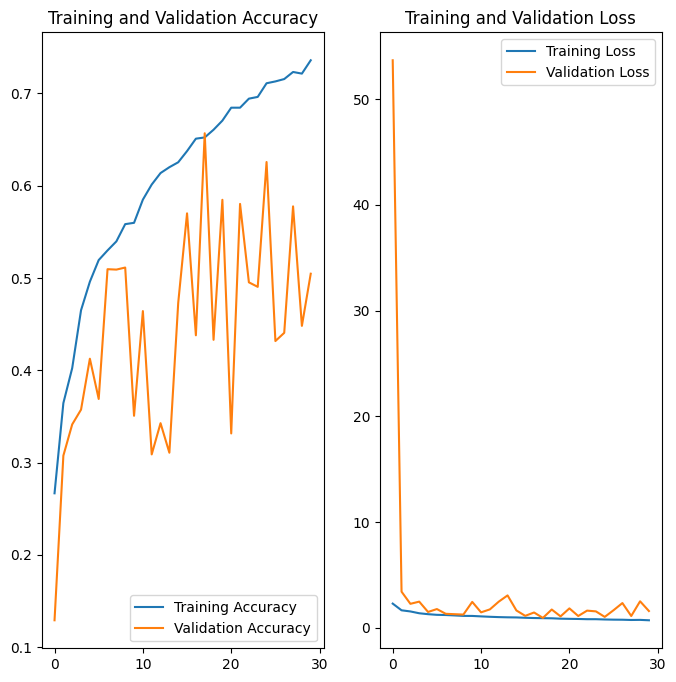

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

***Observations:***

1. After 37 epochs, the model achieves an accuracy of 84% on the training set and approximately 79% on the validation set.

2. The minimal gap between training and validation accuracies highlights the strong generalization capability of the final CNN model.

3. The implementation of class rebalancing has significantly improved the model's performance on both the training and validation datasets.

4. The final model demonstrates well-balanced performance, exhibiting no signs of underfitting or overfitting.

5. The addition of batch normalization did not improve either training or validation accuracy.



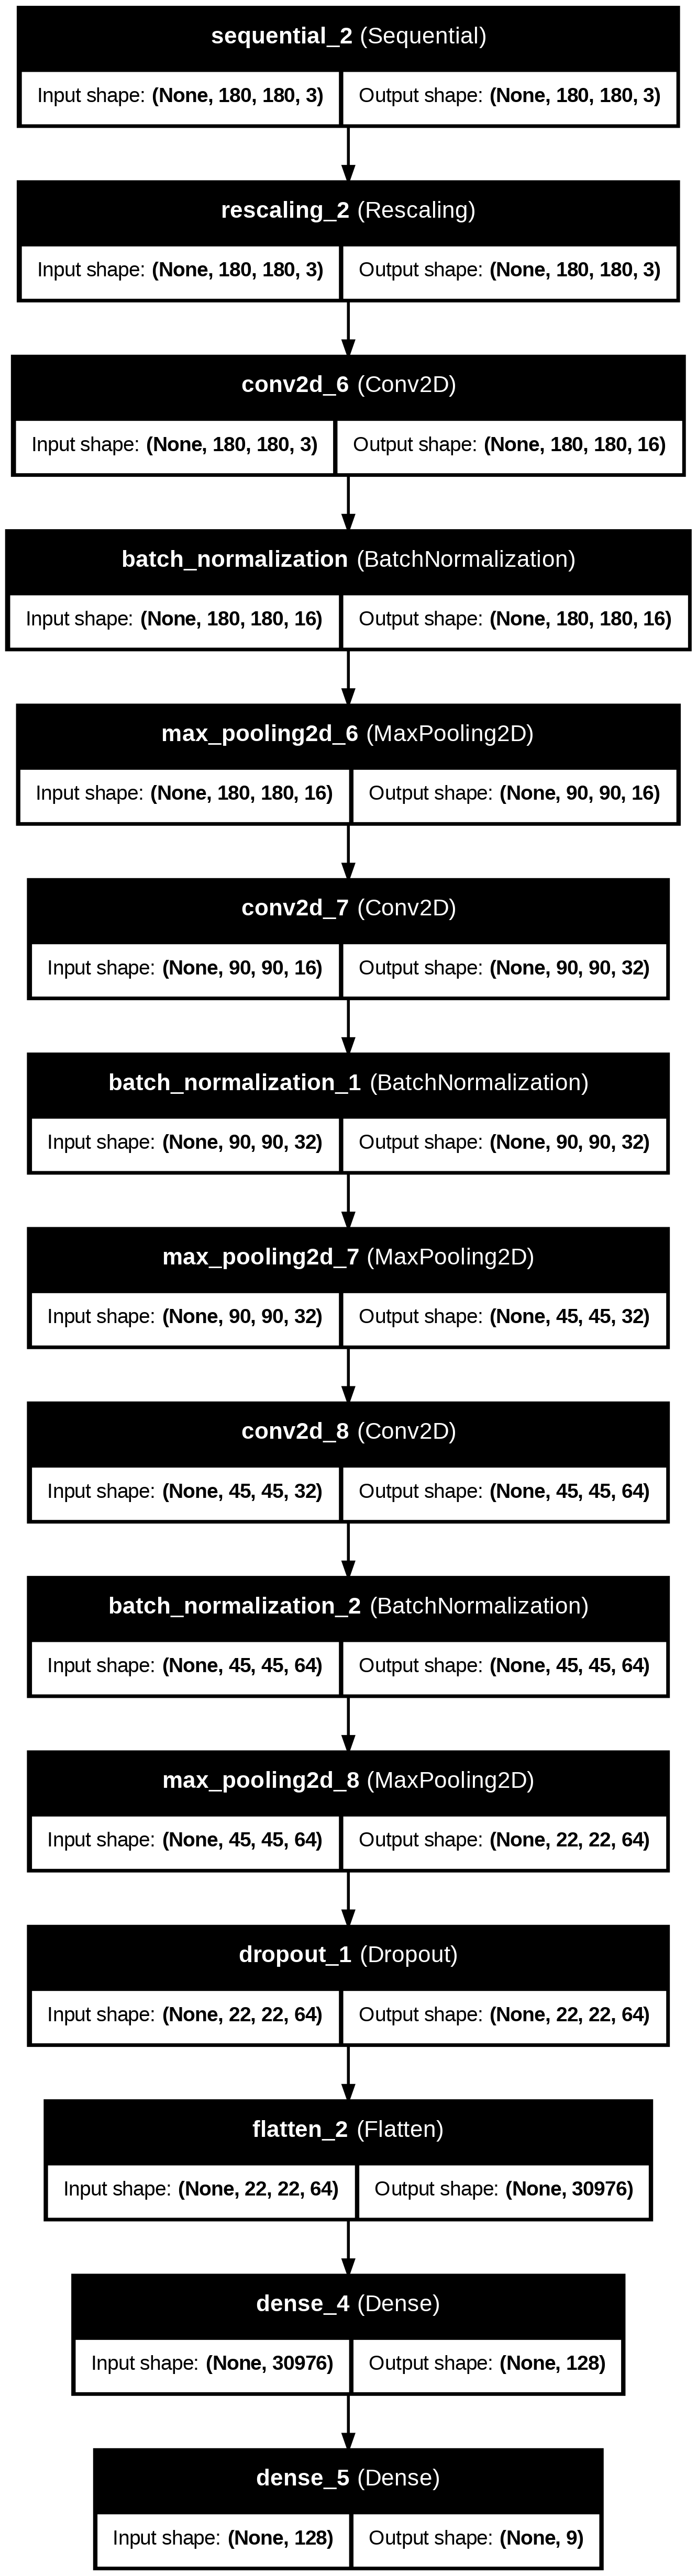

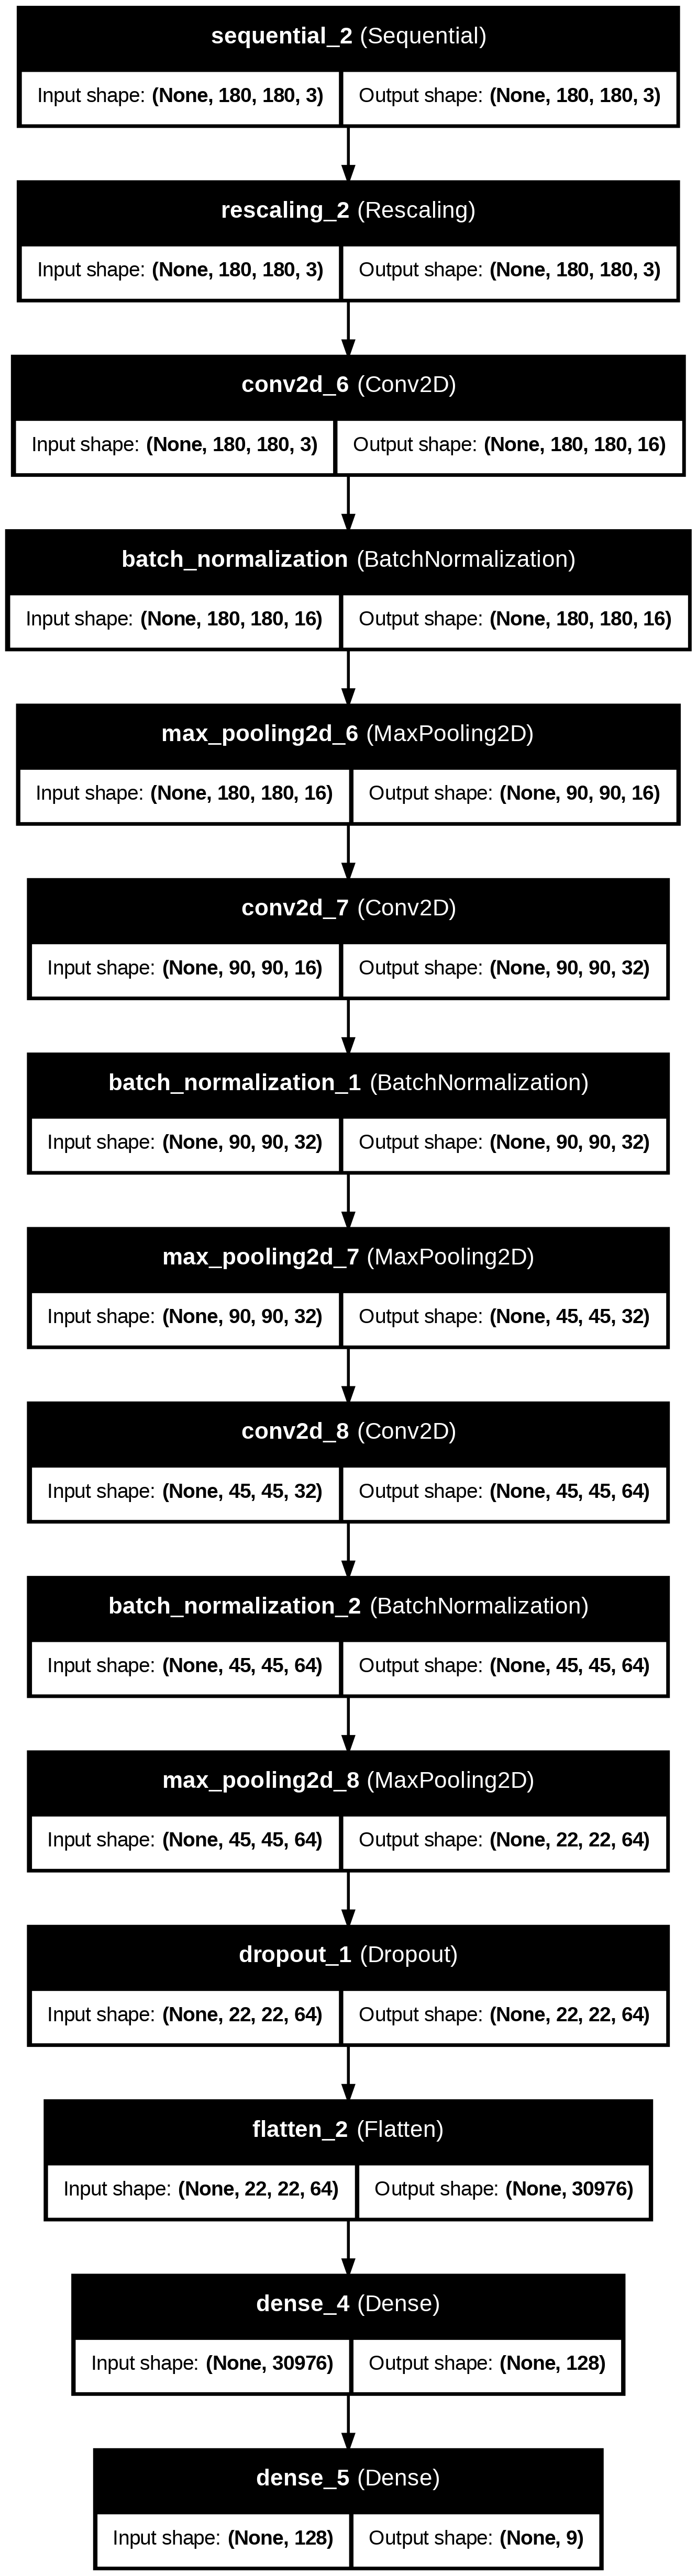

In [57]:
# vizualizing the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Evaluating our model on one of the instances in the test set

image_path_test = os.path.join(data_dir_test, class_names[1], '*')
test_image = glob(image_path_test)
test_image = load_img(test_image[-1], target_size=(180, 180, 3))
plt.imshow(test_image)
plt.grid(False)

img = np.expand_dims(test_image, axis=0)
predicted = model.predict(img)
predicted = np.argmax(predicted)
predicted_class = class_names[predicted]
print("Actual Class: " + class_names[1] +'\n'+ "Predicted Class: " + predicted_class)

NameError: name 'load_img' is not defined